In [1]:
import pandas as pd
from sklearn import preprocessing
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import os, sys, math
import time, timeit
import csv
from sklearn.utils import shuffle

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
# from joblib import dump, load

plt.rc('lines', linewidth=3)
plt.rcParams['hatch.linewidth'] = 2
# plt.rcParams['mathtext.default'] = 'DejaVu Sans'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'

# from IPython.display import Image, display
# from six import StringIO
# from sklearn.tree import export_graphviz
max_cardinality = 1.0
root="/Users/liuguanli/Dropbox/应用/Overleaf/ICDE 2023(revision)/figs"

In [2]:
def read_date(file_name, max_cardinality):
    df = pd.read_csv(file_name, header=None)
    df = df[df[0] <= max_cardinality]
#     print(df)
    train_x = df[[0,1,2,3,4,5,6,7]]    
    train_y1 = df[[8]]    
    train_y2 = df[[9]]
    return train_x, train_y1, train_y2

In [3]:
def build_cost_model(train_x, train_y1, train_y2, name):
    max_depth = 5
    num_of_estimators = 32
    num_of_neurons = 32
    build_models = {
        "$u=4$" : MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', learning_rate='constant', learning_rate_init=0.01, random_state=1, max_iter=5000),
        "$u=5$" : MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', learning_rate='constant', learning_rate_init=0.01, random_state=1, max_iter=5000),
        "$u=6$" : MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', learning_rate='constant', learning_rate_init=0.01, random_state=1, max_iter=5000),
        "$u=7$" : MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', learning_rate='constant', learning_rate_init=0.01, random_state=1, max_iter=5000),
        "$u=8$" : MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', learning_rate='constant', learning_rate_init=0.01, random_state=1, max_iter=5000),
    }
    query_models = {
        "$u=4$" : MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', learning_rate='constant', learning_rate_init=0.01, random_state=1, max_iter=5000),
        "$u=5$" : MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', learning_rate='constant', learning_rate_init=0.01, random_state=1, max_iter=5000),
        "$u=6$" : MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', learning_rate='constant', learning_rate_init=0.01, random_state=1, max_iter=5000),
        "$u=7$" : MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', learning_rate='constant', learning_rate_init=0.01, random_state=1, max_iter=5000),
        "$u=8$" : MLPRegressor(hidden_layer_sizes=(64,64,64), activation='relu', learning_rate='constant', learning_rate_init=0.01, random_state=1, max_iter=5000),
    }
#     if name == "rfr" or name == "dtr" or name == "nn":
    train_y1 = train_y1 / 6
    train_y2 = train_y2 / 6
    train_x[0] /= max_cardinality
    return build_models[name].fit(train_x, train_y1), query_models[name].fit(train_x, train_y2)

In [4]:
def predict_score(models, name, xs, lamb):
    build_model, query_model = models[name]
#     if name == "nn":
#         print( build_model.predict(xs) * lamb, query_model.predict(xs) * (1 - lamb))
    return build_model.predict(xs) * lamb + query_model.predict(xs) * (1 - lamb)

In [5]:
file_name = 'scorer_formatted.csv'  
filters = {"$u=8$":1.0, "$u=7$":0.1, "$u=6$":0.01, "$u=5$":0.001, "$u=4$":0.0001}

models = {}
for key in filters.keys():
    max_cardinality = filters[key]
    train_x, train_y1, train_y2 = read_date(file_name, max_cardinality)
    print(max_cardinality, len(train_y1))
    models[max_cardinality] = build_cost_model(train_x, train_y1, train_y2, key)


1.0 300
0.1 240
0.01 180
0.001 120
0.0001 60


In [6]:
class Record:
    def __init__(self, record):
        self.cardinality = float(record[0])
        self.distribution = float(record[1])
        self.method = list(map(int, record[2:8]))      
        self.build_score = float(record[8])        
        self.query_score = float(record[9])
    
    def is_same(self, record):
        if not math.isclose(self.cardinality, record.cardinality):
            return False
        if not math.isclose(self.distribution, record.distribution):
            return False
        if self.method != record.method:
            return False
        return True
            

    def __str__(self):
        return  str(self.cardinality) + "-" + str(self.distribution) + "-" + str(self.method)+ "-" +str(self.build_score) + "-" + str(self.build_score) + "\n"
    
    def __repr__(self):
                return  str(self.cardinality) + "-" + str(self.distribution) + "-" + str(self.method)+ "-" +str(self.build_score) + "-" + str(self.build_score) + "\n"

In [7]:
def read_records(input_data_file):
    records = []
    with open(input_data_file) as csvfile:
        reader = csv.reader(csvfile, delimiter = ',')
        for i, row in enumerate(reader):
            record = Record(row)
            records.append(record)
    return records

In [8]:
def find_record(target, records):
    for record in records:
        if record.is_same(target):
            return record
    return None

In [9]:
def test_model(records, models):
    distances = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    methods = {'cl':[1,0,0,0,0,0],'mr':[0,1,0,0,0,0],'original':[0,0,1,0,0,0],
                'rl':[0,0,0,1,0,0],'rs':[0,0,0,0,1,0],'sp':[0,0,0,0,0,1]}
    cardinality = {"$u=8$":1.0, "$u=7$":0.1, "$u=6$":0.01, "$u=5$":0.001, "$u=4$":0.0001}
    
    lambdas = [0.1 * i for i in range(11)]
    checked_lambda = 0.1
    checked_name = "no" #"NN"
    model_names = models.keys()
    res = {}
    for name in model_names:
        res[name] = []
    for lamb in lambdas:
        model_accuracy = {}
        
        model_incorrect_source = {}
        model_incorrect_target = {}
        
        total_num = 0
        for name in model_names:
            model_accuracy[name] = 0
            model_incorrect_source[name] = []
            model_incorrect_target[name] = []
        for card_key in cardinality.keys():
            card = cardinality[card_key]
            for dist in distances:
                # here find a method
                best_method = []
                max_score = -100
                missed_candidate = []
                if name == checked_name and math.isclose(lamb, checked_lambda):
                    print('---------------real---------------')
                
                for method in methods.keys():
                    record = []
                    record.append(card)
                    record.append(dist)
                    record.extend(methods[method])
                    record.append(0)
                    record.append(0)
                    temp = Record(record)
                    result = find_record(temp, records)
                    if result is None:
                        missed_candidate.append(temp)
                        print(temp)
                        continue
                    current_score = float(result.build_score * lamb) + float(result.query_score * (1 - lamb))
                    if name == checked_name and math.isclose(lamb, checked_lambda):
                        print("current_score", method, current_score)
                    if current_score > max_score:
                        max_score = current_score
                        best_method = []
                        best_method.append(method)
                        continue
                        
                    if math.isclose(current_score, max_score):
                        best_method.append(method)
#                 if best_method == '':
#                     continue
#                 if math.isclose(lamb, 0.0) and len(missed_candidate) > 0:
#                     print(missed_candidate[0])
#                 print("lambda", lamb, "cardinality", card, "distribution", dist, "method", best_method)
                total_num += 1
                for name in model_names:
                    max_score = -100
                    choosed_method = ''
                    if name == checked_name and math.isclose(lamb, checked_lambda):
                        print('---------------predict---------------')
                    for method in methods.keys():
                        record = []
                        record.append(card)
                        record.append(dist)
                        record.extend(methods[method])
                        current_score = predict_score(models, name, [record], lamb)
                        if name == checked_name and math.isclose(lamb, checked_lambda):
                            print("current_score", method, current_score)
                        
                        if current_score > max_score:
                            max_score = current_score
                            choosed_method = method
#                     print(name, choosed_method, best_method, choosed_method == best_method)
                    if choosed_method in best_method:
                        model_accuracy[name] = model_accuracy[name] + 1
                    else:
                        model_incorrect_source[name].append((best_method, choosed_method))
#                     else:
                        if name == checked_name and math.isclose(lamb, checked_lambda):
                            print(card, dist)
                            print(name, "best_method:", best_method, "choosed_method:", choosed_method)
        for name in model_names:
            model_accuracy[name] = round(model_accuracy[name] / total_num, 2)
            if name == checked_name and math.isclose(lamb, checked_lambda):
                text_template = "---------lambda={la}----incorrect prediction of-----{name}:"
                print(text_template.format(la=round(lamb,1), name=name))
                print(model_incorrect_source[name])
        print(model_accuracy)
        for name in model_names:
            res[name].append(model_accuracy[name])
#     for name in model_names:
#         print(res[name])
    return res     
res = test_model(read_records(file_name), models)  

{1.0: 0.82, 0.1: 0.58, 0.01: 0.52, 0.001: 0.64, 0.0001: 0.48}
{1.0: 0.78, 0.1: 0.38, 0.01: 0.44, 0.001: 0.48, 0.0001: 0.38}
{1.0: 0.82, 0.1: 0.42, 0.01: 0.54, 0.001: 0.48, 0.0001: 0.42}
{1.0: 0.82, 0.1: 0.38, 0.01: 0.56, 0.001: 0.58, 0.0001: 0.44}
{1.0: 0.78, 0.1: 0.42, 0.01: 0.58, 0.001: 0.62, 0.0001: 0.58}
{1.0: 0.78, 0.1: 0.54, 0.01: 0.72, 0.001: 0.72, 0.0001: 0.62}
{1.0: 0.68, 0.1: 0.58, 0.01: 0.68, 0.001: 0.68, 0.0001: 0.64}
{1.0: 0.74, 0.1: 0.74, 0.01: 0.72, 0.001: 0.7, 0.0001: 0.7}
{1.0: 0.96, 0.1: 0.96, 0.01: 0.96, 0.001: 0.96, 0.0001: 0.96}
{1.0: 1.0, 0.1: 1.0, 0.01: 1.0, 0.001: 1.0, 0.0001: 1.0}
{1.0: 1.0, 0.1: 1.0, 0.01: 1.0, 0.001: 1.0, 0.0001: 1.0}


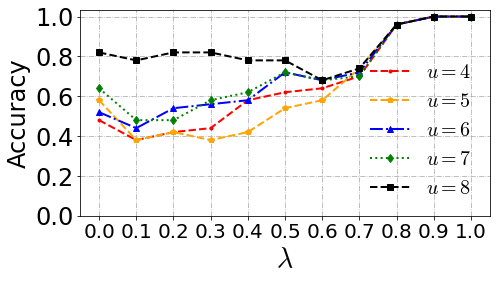

In [10]:
plt.rcParams["figure.figsize"] = (7,4)
x = [i for i in range(11)]
lw = 2

labelsize=24
fontsize=24
legend_fontsize=20
y=[1 for i in range(11)]

colors = ['red', 'orange', 'blue', 'green', 'black', "purple", "red"]
markers = ['.', 'p', '^', 'd', 's', 'o', 'v']
linestyles = ['--', '--', '-.', ':', '--', "-.", '-.']
texts = ['$u=4$', '$u=5$', '$u=6$', '$u=7$', '$u=8$']
cardinality = {"$u=8$":1.0, "$u=7$":0.001, "$u=6$":0.01, "$u=5$":0.1, "$u=4$":0.0001}
model_names = models.keys()
for i,name in enumerate(texts):
    plt.plot(x, res[cardinality[texts[i]]],label=name,marker=markers[i],color=colors[i],linestyle=linestyles[i],linewidth=lw)


plt.tick_params(labelsize=fontsize)
# x_ticks = np.arange(0, 16/15, 4/16)
x_ticks = [round(0.1 * i,1) for i in range(11)]
plt.xticks(range(len(x_ticks)), x_ticks, fontsize=20)
# plt.xticks(x_ticks)
# plt.fill_between(x, y1, y2,
#                  facecolor="orange", # The fill color
#                  color='#DDA0DD',       # The outline color
#                  alpha=0.2)          # Transparency of the fill
plt.xlabel("$\lambda$",fontsize=28)
plt.ylabel("Accuracy",fontsize=fontsize)
# plt.yscale('log')
# plt.ylim([1, 10000])
plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.legend(fontsize=legend_fontsize, ncol=1,frameon=False)
plt.grid(True, linestyle='-.')

plt.tight_layout()
plt.savefig(root + "/training_time_cardinality_accuracy.eps", format='eps', bbox_inches='tight')
plt.savefig(root + "/training_time_cardinality_accuracy.pdf", format='pdf', bbox_inches='tight')

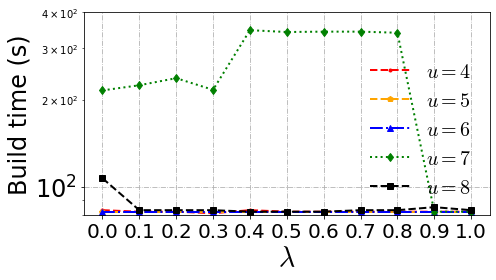

In [11]:
plt.rcParams["figure.figsize"] = (7,4)
x = [i for i in range(11)]
lw = 2

labelsize=24
fontsize=24
legend_fontsize=20
y=[1 for i in range(11)]

ys=[[83, 82, 82, 81, 83, 82, 82, 82, 82, 82, 82],
[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82],
[82, 82, 82, 82, 82, 82, 82, 82, 82, 82, 82],
[215, 224, 237, 216, 347, 342, 343, 343, 340, 82, 82],
[107, 83, 83, 83, 82, 82, 82, 83, 83, 85, 83],]


colors = ['red', 'orange', 'blue', 'green', 'black', "purple", "red"]
markers = ['.', 'p', '^', 'd', 's', 'o', 'v']
linestyles = ['--', '--', '-.', ':', '--', "-.", '-.']
texts = ['$u=4$', '$u=5$', '$u=6$', '$u=7$', '$u=8$']
model_names = models.keys()
for i,name in enumerate(model_names):
    plt.plot(x, ys[i],label=texts[i],marker=markers[i],color=colors[i],linestyle=linestyles[i],linewidth=lw)


plt.tick_params(labelsize=fontsize)
# x_ticks = np.arange(0, 16/15, 4/16)
x_ticks = [round(0.1 * i,1) for i in range(11)]
plt.xticks(range(len(x_ticks)), x_ticks, fontsize=20)
# plt.xticks(x_ticks)
# plt.fill_between(x, y1, y2,
#                  facecolor="orange", # The fill color
#                  color='#DDA0DD',       # The outline color
#                  alpha=0.2)          # Transparency of the fill
plt.xlabel("$\lambda$",fontsize=28)
plt.ylabel("Build time (s)",fontsize=fontsize)
plt.yscale('log')
plt.ylim([80, 400])
plt.legend(fontsize=legend_fontsize, ncol=1,frameon=False)
plt.grid(True, linestyle='-.')

plt.tight_layout()
# plt.savefig(root + "/training_time_cardinality_accuracy.eps", format='eps', bbox_inches='tight')
# plt.savefig(root + "/training_time_cardinality_accuracy.pdf", format='pdf', bbox_inches='tight')

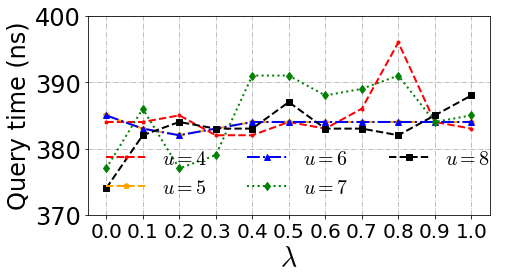

In [12]:
plt.rcParams["figure.figsize"] = (7,4)
x = [i for i in range(11)]
lw = 2

labelsize=24
fontsize=24
legend_fontsize=20
y=[1 for i in range(11)]

ys=[[384, 384, 385, 382, 382, 384, 383, 386, 396, 384, 383],
[385, 383, 382, 383, 384, 384, 384, 384, 384, 384, 384],
[385, 383, 382, 383, 384, 384, 384, 384, 384, 384, 384],
[377, 386, 377, 379, 391, 391, 388, 389, 391, 384, 385],
[374, 382, 384, 383, 383, 387, 383, 383, 382, 385, 388],]

colors = ['red', 'orange', 'blue', 'green', 'black', "purple", "red"]
markers = ['.', 'p', '^', 'd', 's', 'o', 'v']
linestyles = ['--', '--', '-.', ':', '--', "-.", '-.']
texts = ['$u=4$', '$u=5$', '$u=6$', '$u=7$', '$u=8$']
model_names = models.keys()
for i,name in enumerate(model_names):
    plt.plot(x, ys[i],label=texts[i],marker=markers[i],color=colors[i],linestyle=linestyles[i],linewidth=lw)


plt.tick_params(labelsize=fontsize)
# x_ticks = np.arange(0, 16/15, 4/16)
x_ticks = [round(0.1 * i,1) for i in range(11)]
plt.xticks(range(len(x_ticks)), x_ticks, fontsize=20)
# plt.xticks(x_ticks)
# plt.fill_between(x, y1, y2,
#                  facecolor="orange", # The fill color
#                  color='#DDA0DD',       # The outline color
#                  alpha=0.2)          # Transparency of the fill
plt.xlabel("$\lambda$",fontsize=28)
plt.ylabel("Query time (ns)",fontsize=fontsize)
# plt.yscale('log')
plt.ylim([370, 400])
# plt.yticks([0,0.2,0.4,0.6,0.8,1.0])
plt.legend(fontsize=legend_fontsize, ncol=3,frameon=False)
plt.grid(True, linestyle='-.')

plt.tight_layout()
# plt.savefig(root + "/training_time_cardinality_accuracy.eps", format='eps', bbox_inches='tight')
# plt.savefig(root + "/training_time_cardinality_accuracy.pdf", format='pdf', bbox_inches='tight')